# Метод **Рунге — Кутты** для решения дифференциальных уравнений.

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

%matplotlib inline

Рассмотрим дифференциальное уравнение типа $$\frac{d y(x)}{dx} = f(x)$$ с начальным условием $$y(x_0) = y_0 $$


Его можно решать **методом Эйлера**. То есть, зная из начальных условий значение искомой функции в одной точке $y(x_0) = y_0$ и зная из дифференциального уравнения производную функции в этой точке $y'(x_0)=f(x_0)$ можно найти значене функции в точке $x_0 + \Delta x$ как: 

$$ y(x_0 + \Delta x) = y(x_0) + y'(x_0)\Delta x \label{euler}\tag{1}$$

Описаный метод приводит к накоплению ошибки по ходу вычислений.

## Численное решение дифференциальных уравнений

Введем функцию __initial_function__, которая будет являться искомой функцией $y(x)$. Искомая функция нужна, для того чтобы у нас в дальнейцем была возможность сравнивать полученное решение с точным и, например, оценивать его точность.

In [2]:
def initial_function(x, *args):
    return np.exp(x)

Для составления дифференциального уравнения необходиа производная этой функции.

Напишем новую функцию, которая принимает любую функцию в качестве аргумента и возвращает её призводную.

С помощью этой функции возьмем производную от __initial_function__.

Сразу же укажем шаг $dx$ с которым берем производную. Чем меньше шаг, тем точнее будем производная.

In [3]:
def derivative(func, dx):
    def f(x, *args):
        return (func(x+dx/2, *args) - func(x-dx/2, *args))/(dx)
    return f

dx = 1e-3
f = derivative(initial_function, dx)

Теперь у нас есть все необходимое для решения дифферениального уравнения.

Сначала решим уравнение методом Эйлера, то есть $$x_{n+1} = x_n + dx$$ $$y_{n+1} = y_n + f(x_n)dx$$

In [4]:
def get_next_point(x0,y0,dx,f,get_slope):
    x1 = x0 + dx
    y1 = y0 + get_slope(f, x0)*dx
    return x1, y1

def solve(f, x0, y0, dx, x_max, get_slope):
    x = []
    y = []

    x.append(x0)
    y.append(y0)

    while x[-1] < x_max:
        x0 = x[-1]
        y0 = y[-1]
        
        x1, y1 = get_next_point(x0, y0, dx, f, get_slope)
        
        x.append(x1)
        y.append(y1)
    return x, y

В  в методе Эйлера, в качестве функции __get_slope__, которая возвращает производную функции в интересующей точке, используем просто значение $f(x_0)$:

In [5]:
def get_euler_slope(f, x0):
    return f(x0)

Зададим начальные условия, облать в которой ищем решение и величину шага

In [6]:
x0 = 0
y0 = initial_function(x0)

x_max = 10
step = 0.5

Решаем уравнение посторим полученное решение и сравним с имеющимся у нас точным решением:

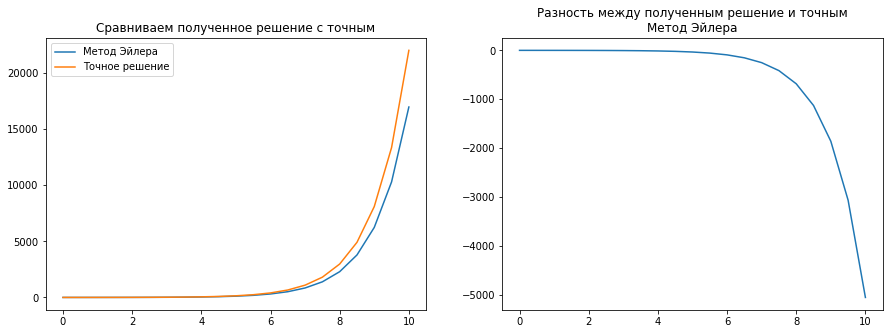

In [7]:
solution = solve(f, x0, y0, step, x_max, get_euler_slope)
sol_x = np.array(solution[0])
sol_y = np.array(solution[1])

exact_solution = initial_function(sol_x) # оценим точное значение искомой функции в точках, где у нас есть решение, чтоб можно было сравнить

fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].set_title('Сравниваем полученное решение с точным')
ax[1].set_title('Разность между полученным решение и точным\nМетод Эйлера')

ax[0].plot(sol_x, sol_y, label='Метод Эйлера');
ax[0].plot(sol_x, exact_solution, label='Точное решение');
ax[0].legend();

difference = sol_y - exact_solution
ax[1].plot(sol_x, difference, label='Метод Эйлера');

Видим, что полученное решение не совпадает с точным, особенно при больших значениях шага __step__. Например, при величине шага 0.5 полученное решение отличается от точного на 5000 в крайней правой точке.

Уменьшение шага позволяет получить более точное решение, но приводит к пропорциональному увеличению времени расчета, что не всегда приемлемо.

Для получения быстрого и точного решения применяется **метод Рунге — Кутты**.

Вспомним вид разложения Тейлора:
$$ y(x_0+\Delta x) = \sum_{n=0}^{k}\frac{f^{(n)}(x_0)\Delta x^n}{n!} + O(\Delta x^k)$$

Если расписать первые несколько членов:
$$ y(x_0+\Delta x) = f(x_0) +\frac{f'(x_0)\Delta x}{1!} + \frac{f''(x_0)\Delta x^2}{2!} + \frac{f'''(x_0)\Delta x^3}{3!} + O(\Delta x^4) $$
Вынесем $\Delta x$:
$$ y(x_0+\Delta x) = f(x_0) +\Delta x \left(\frac{f'(x_0)}{1!} + \frac{f''(x_0)\Delta x}{2!} + \frac{f'''(x_0)\Delta x^2}{3!}\right) + O(\Delta x^4) $$
Чем больше слагаемых мы учтем в этой скобке, тем более точным будет наше приближение. Полученное выражение по форме очень похоже на уравнение $(1)$, только вместо $y'(x_0)$ в нем стоит скобка $\left(\frac{f'(x_0)}{1!} + \frac{f''(x_0)\Delta x}{2!} + ...\right)$. Таким образом содержимое этой скобки можно интерпретировать как "эффективную производную" функции $y(x)$ в точке $x_0$. Тогда мы можем использовать уже имеющийся готовый алгоритм решения с помощью метода Эйлера, в нем только надо заменить функцию __get_euler_slope__ на функцию, которая вычисляет "эффективную производную". Это и есть метод Рунге — Кутты.

Создадим функцию __get_RK_slope__ принимает в качестве аргумента число слагаемых __number_of_terms__,и возвращает функцию, которая аналогична __get_euler_slope__, но вычисляет уже "эффективную производную", учитывая необходимое число слагаемых __number_of_terms__

In [8]:
def get_RK_slope(number_of_terms, dx):
    def RK_slope(f, x0, n=number_of_terms, out=0, i=1):
        out += f(x0)/math.factorial(i)*dx**(i-1)

        if n == 0:
            return out  

        df = derivative(f, dx)

        return RK_slope(df,x0, n-1, out, i+1)
    return RK_slope

Используя эту функцию __get_RK_slope__ вместо функции __get_euler_slope__ в уже имеющемся алгоритме получим более точное решение:

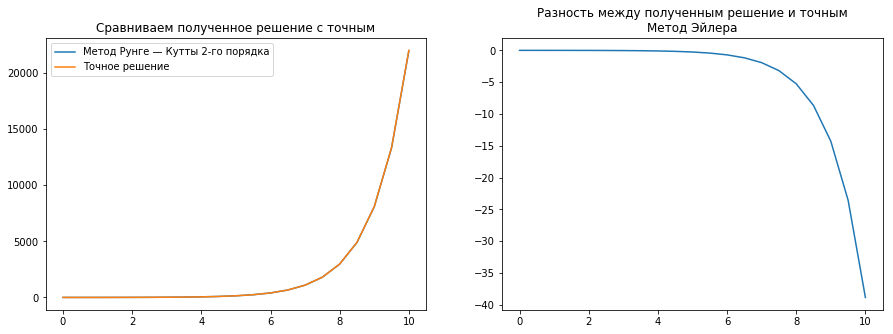

In [9]:
RK_order = 2

solution = solve(f, x0, y0, step, x_max, get_RK_slope(RK_order, step))
sol_x = np.array(solution[0])
sol_y = np.array(solution[1])

exact_solution = initial_function(sol_x) # оценим точное значение искомой функции в точках, где у нас есть решение, чтоб можно было сравнить

fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].set_title('Сравниваем полученное решение с точным')
ax[1].set_title('Разность между полученным решение и точным\nМетод Эйлера')

ax[0].plot(sol_x, sol_y, label='Метод Рунге — Кутты {}-го порядка'.format(RK_order));
ax[0].plot(sol_x, exact_solution, label='Точное решение');
ax[0].legend();

difference = sol_y - exact_solution
ax[1].plot(sol_x, difference, label='Метод Эйлера');

 Примениение метода Рунге — Кутты к той же самой задаче с тем же самым шагом 0.5 позволяет получить решение отличающееся от эталонного уже не на 5000, а всего на 40. То есть ошибка в 125 раз меньше.
 
 Если получается более точное решение, наверно, на это тратится больше вычислительного времени. Оценим время требуемое для работы каждого из алогоритмов. _Ячейки с оценкой времени можно закомментить, чтоб не тратить на них время_

In [10]:
%%timeit
# Метод Эйлера
solve(f, x0, y0, step, x_max, get_euler_slope)

141 µs ± 9.93 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [11]:
%%timeit
# Метод Рунге — Кутты 2-го порядка
solve(f, x0, y0, step, x_max, get_RK_slope(2, step))

996 µs ± 95.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Время, которое требуется для решения методом Рунге-Кутты всего в ~ 5 раз больше, зато решение получается более чем в 100 раз более точное

##  Решение методом Рунге — Кутты с помощью модуля *scipy*

В библиотеке scipy есть встроенный решатель дифференциальных уравнений использующий метод Рунге — Кутты. Можно пользоваться им для того чтобы каждый раз не писать алгоритм с нуля:

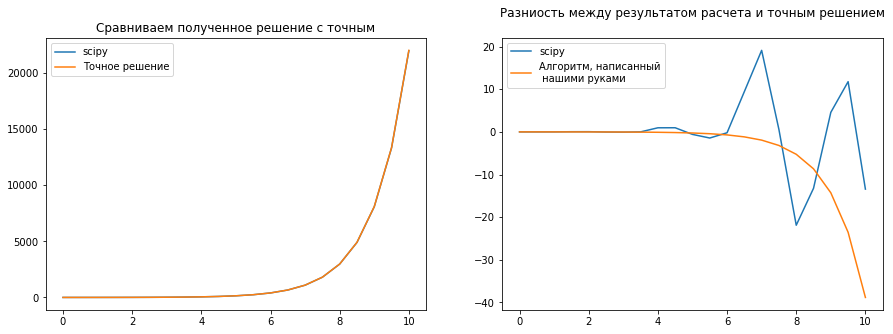

In [12]:
from scipy.integrate import solve_ivp

# sol_x, sol_y берутся из ячейки в которой ур-е решается методом РК

# можно раскомментить наачальные условия и параметры решения, чтоб ячейка была самодостаточная
# x0 = 0
# y0 = initial_function(x0)
# x_max = 10
# step = 0.5


x = sol_x # в качестве точек в которых будем искать решения можно взяли точки из нашего самодельного алгоритма, чтоб потом можно было сравнить точность
# x = np.arange(x0,x_max+step,step) # а можно построить снова, чтоб ячейка была самодостаточная
exact = initial_function(sol_x)

sol = solve_ivp(f, [x0, x_max+step], [y0], method='RK45', t_eval=x)

fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].set_title('Сравниваем полученное решение с точным')
ax[1].set_title('Разница между полученным решение и точным\nМетод Эйлера')

ax[0].plot(sol_x, sol_y, label='scipy');
ax[0].plot(sol_x, exact_solution, label='Точное решение');
ax[0].legend();

ax[1].set_title('Разниость между результатом расчета и точным решением\n')
ax[1].plot(sol.t, sol.y[0]-exact, label='scipy')
ax[1].plot(sol_x, sol_y-exact, label='Алгоритм, написанный\n нашими руками');
ax[1].legend();

Точность решения для самодельного алгоритма не уступает методу взятому "из коробки". Оценим время работы алогоритма из пакета scipy:

In [13]:
%%timeit
# Scipy
solve_ivp(f, [x0, x_max], [y0], method='RK45', t_eval=x)

1.99 ms ± 282 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Время требуемое на расчет сопоставимо (в полтора-два раза больше) времени, для алгоритма написанного руками.

Итого, написанный руками алгоритм похож на готовый и по точности результата, и по скорости работы. Но пользоваться готовым должно быть удобнее.

### P.S.

В качестве __initial_function__ была взята экспонента, можно поиграться и пробовать любые другие функции. Все должно работать.

При увеличении числа слагаемых, учитываемых в расчете "эффективной производной" в методе РК, точность не возрастает, а порой даже падает. Хз почему. Оптимальное число слагаемых = 2.